In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [3]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2
count,300.000000,300.000000
mean,84.138769,9.979408
std,77.917955,117.978412
min,-181.190181,-374.445022
25%,35.786394,-59.339309
50%,83.158128,34.019343
75%,131.776480,93.596696
max,307.157526,258.940851


In [4]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([1.11018683]), array([[-0.02146303,  0.02909487]]))

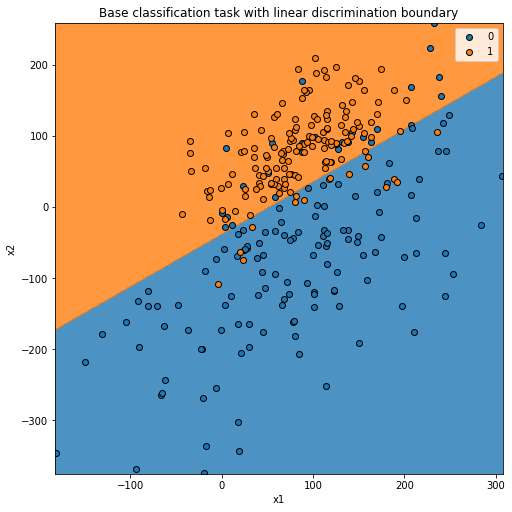

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_,
                       fig=fig, ax=ax)

In [6]:
clf_a = lm

In [7]:
from sklearn.dummy import DummyClassifier
clf_b = DummyClassifier(strategy='uniform', random_state=0)
clf_b.fit(X, y)

DummyClassifier(random_state=0, strategy='uniform')

In [8]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

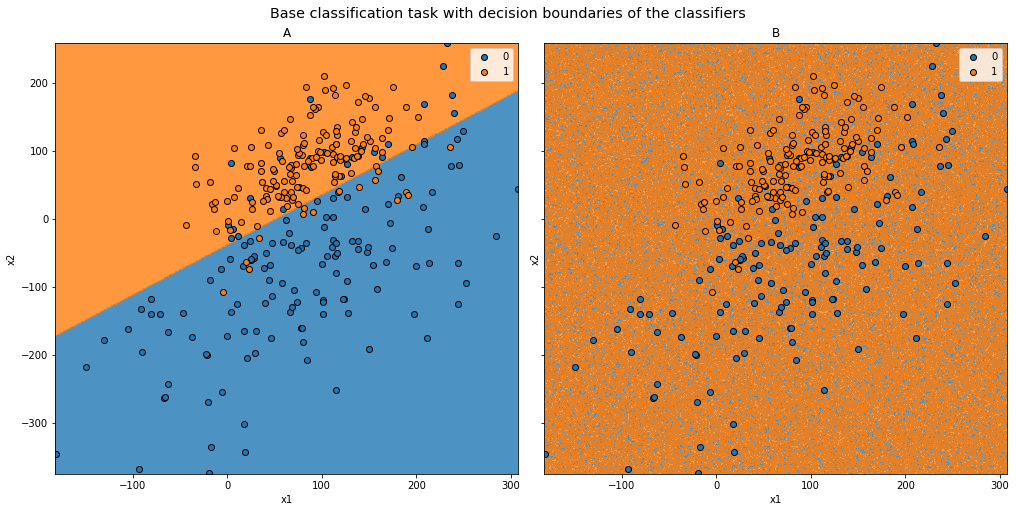

In [9]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', mesh_step_size=1)

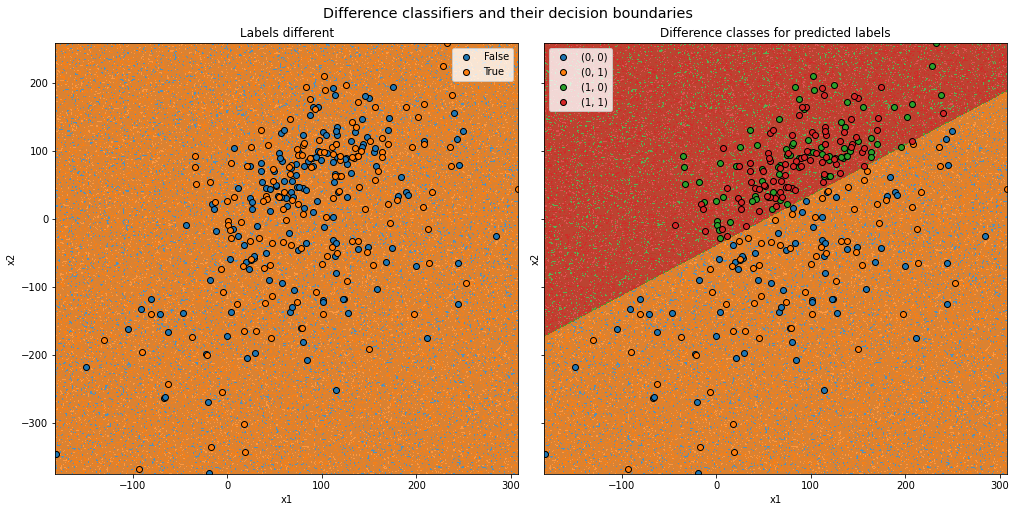

In [10]:
comparer.plot_decision_boundaries(X, mesh_step_size=1)

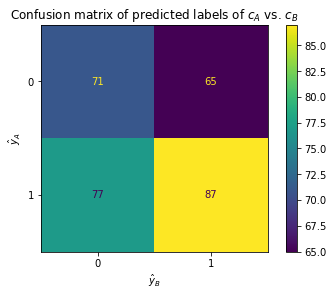

In [11]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [12]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.53 s, sys: 94.4 ms, total: 5.62 s
Wall time: 5.87 s


In [13]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [14]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Both classifiers rely more on x2. x1 is less important to A than to B.

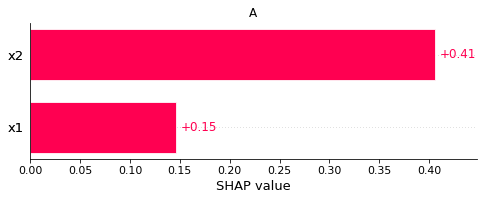

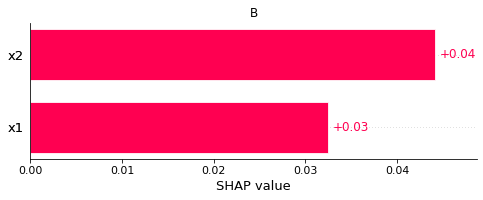

In [15]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [18]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [23]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

For A we see that low feature values decrease the outcome, high feature values increase it. Compared to the task with only one informative feature, the shift is gradual. For B, the effect is constant.

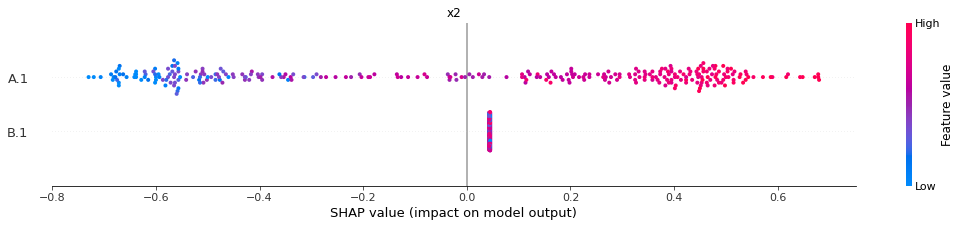

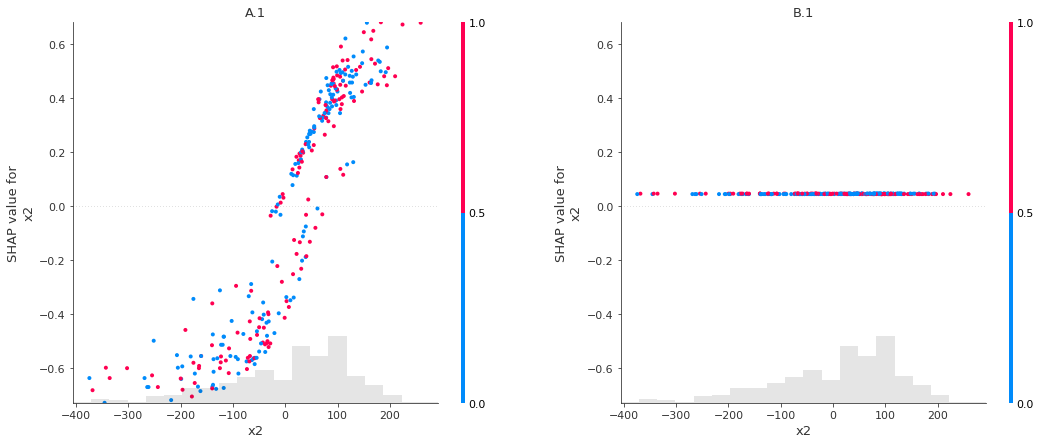

In [24]:
plot_next_feature()

Low values of x2 have an increasing effect on the outcome of A, high values a decreasing effect. The effect on B is constant.

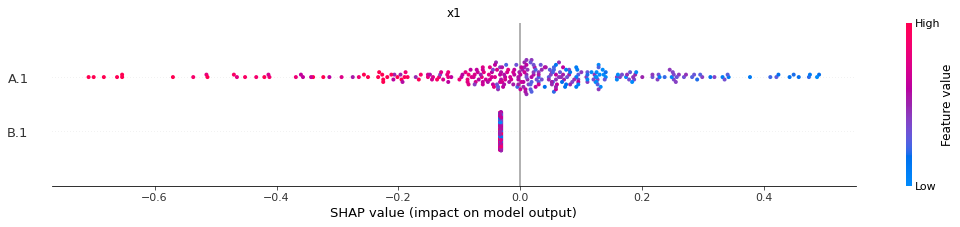

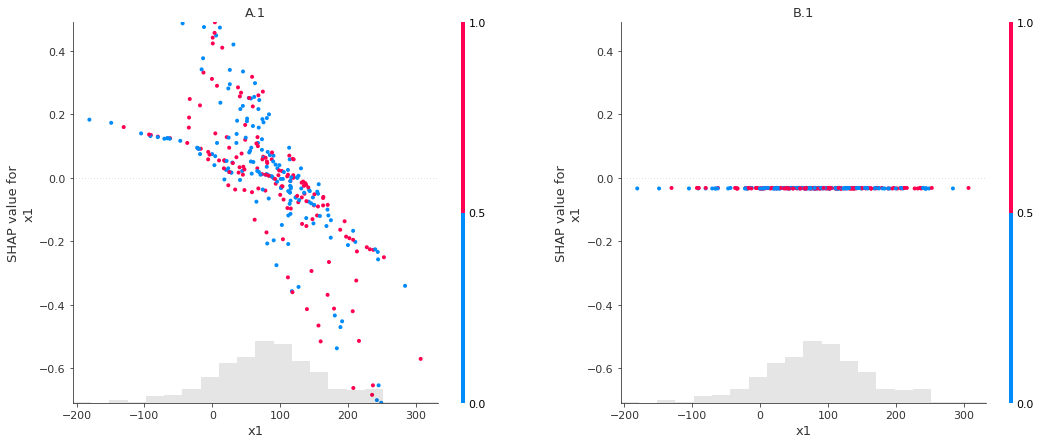

In [25]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

For the differences, x2 is more important than x1.

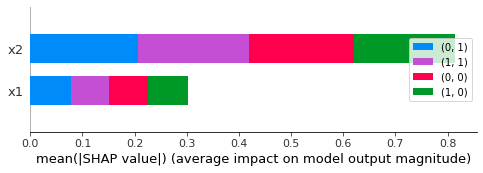

In [26]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

The classes are nearlly equally important. I will stick to the original ordering.

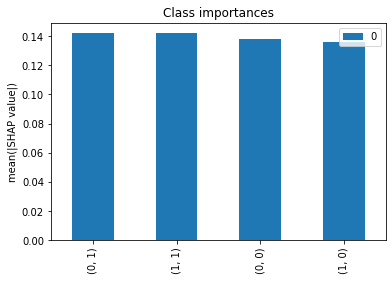

In [27]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [28]:
class_order = np.sort(class_order)

In [29]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

Low feature values increase the effect of $(0,0)$ and $(0,1)$, high feature values increase the effect of $(1,0)$ and $(1,1)$.

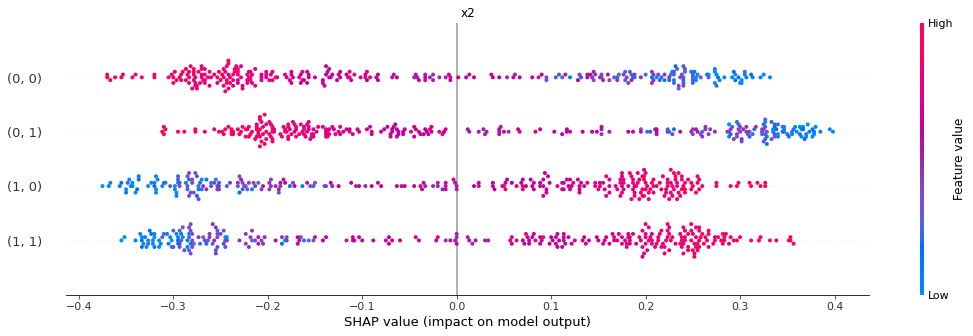

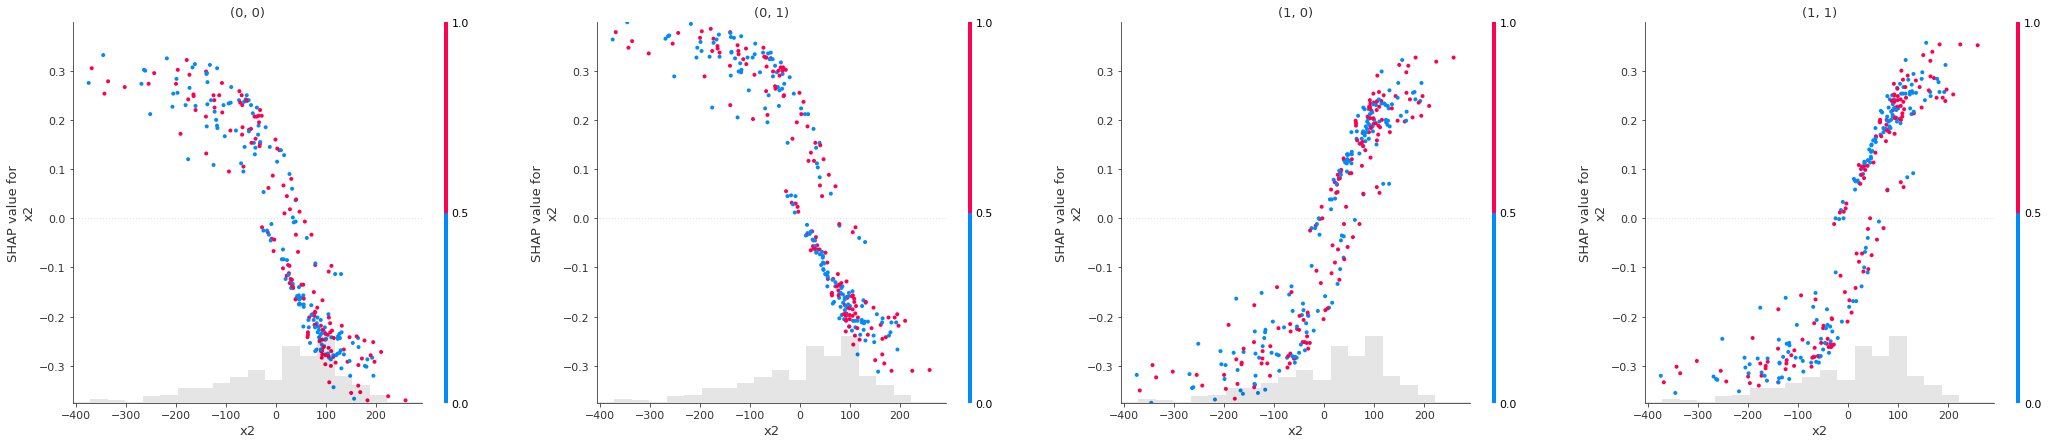

In [30]:
plot_next_feature()

For x2 it's the opposite. Low feature values increase the effect towards $(0,1)$ and $(0,0)$, high feature values increase the effect towards $(1,0)$ and $(1,1)$.

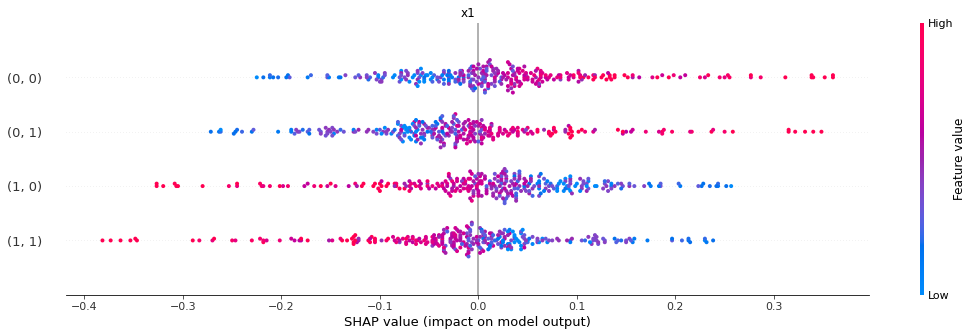

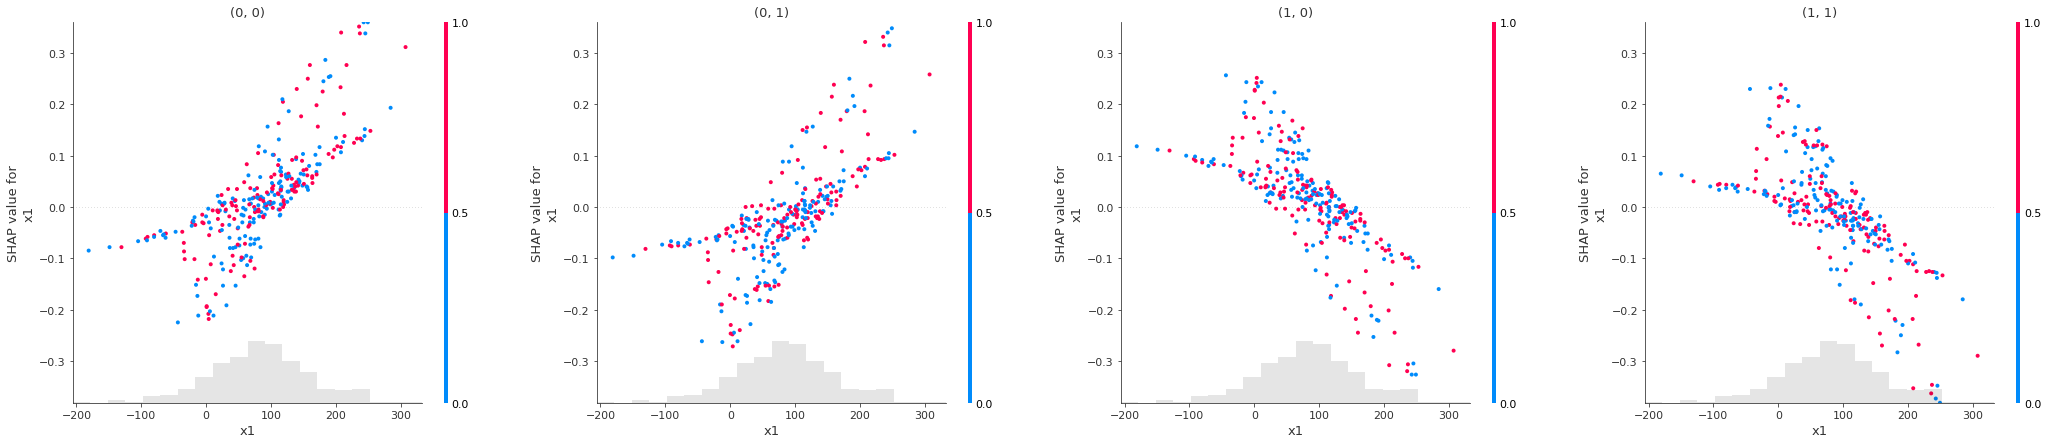

In [31]:
plot_next_feature()

# Local Explanations

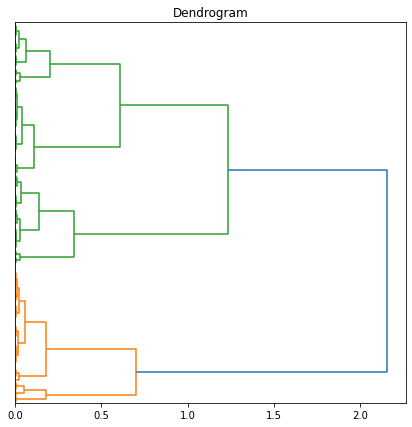

In [32]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

Using $n=4$ yields separate pairs of classes for the first time.

In [41]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,0,0
c2,0,0,39,53
c3,0,0,31,41
c4,56,63,0,0


In [42]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

These feature value distributions are different locally compared to the global level:
- x2 reaches only from 16 to 130
- x1 reaches only from 139 upwards

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x2 was higher, the effect would shift towards $(1,0)$ and $(1,1)$: Setting it to 200 changes all predictions of instances originally classified $(0,1)$ to $(1,1)$, and all predictions of instances originally classified $(0,0)$ to $(1,0)$.
- if x1 was lower, the effect would shift towards $(1,1)$ and $(1,0)$: Setting it to -100 changes all predictions of instances originally classified $(0,1)$ to $(1,1)$, and all predictions of instances originally classified $(0,0)$ to $(1,0)$.

Using the local explanations I can interpret that:
- if x2 was higher, the effect would shift towards $(1,0)$ and $(1,1)$: Setting it to 120 changes 7/10 predictions of instances originally classified $(0,1)$ to $(1,1)$, and 3/7 predictions of instances originally classified $(0,0)$ to $(1,0)$.

In [43]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,7,10,0,0


In [44]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,17.000000,17.000000
mean,207.466045,64.471524
std,42.003620,34.325470
min,139.484363,16.934925
25%,180.583643,39.340946
50%,206.993135,57.678166
75%,236.754283,78.696460
max,307.157526,130.025070


In [47]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = 200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",7.0,NaN
"(1, 0)",NaN,7.0


,before,after
"(0, 1)",10.0,NaN
"(1, 1)",NaN,10.0


In [48]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",7.0,NaN
"(1, 0)",NaN,7.0


,before,after
"(0, 1)",10.0,NaN
"(1, 1)",NaN,10.0


### SHAP-based Difference Classifier Explanations

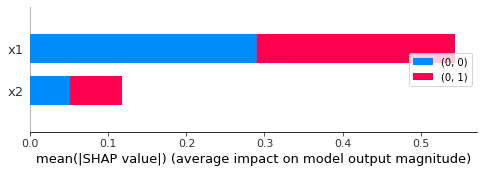

In [49]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

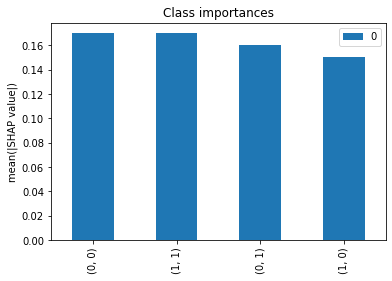

In [50]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [51]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

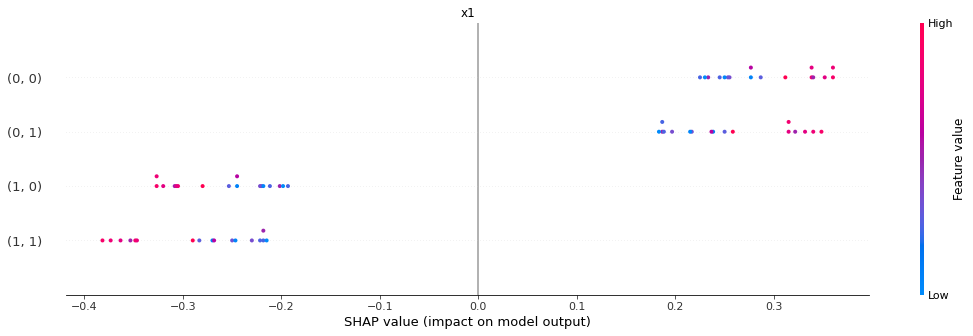

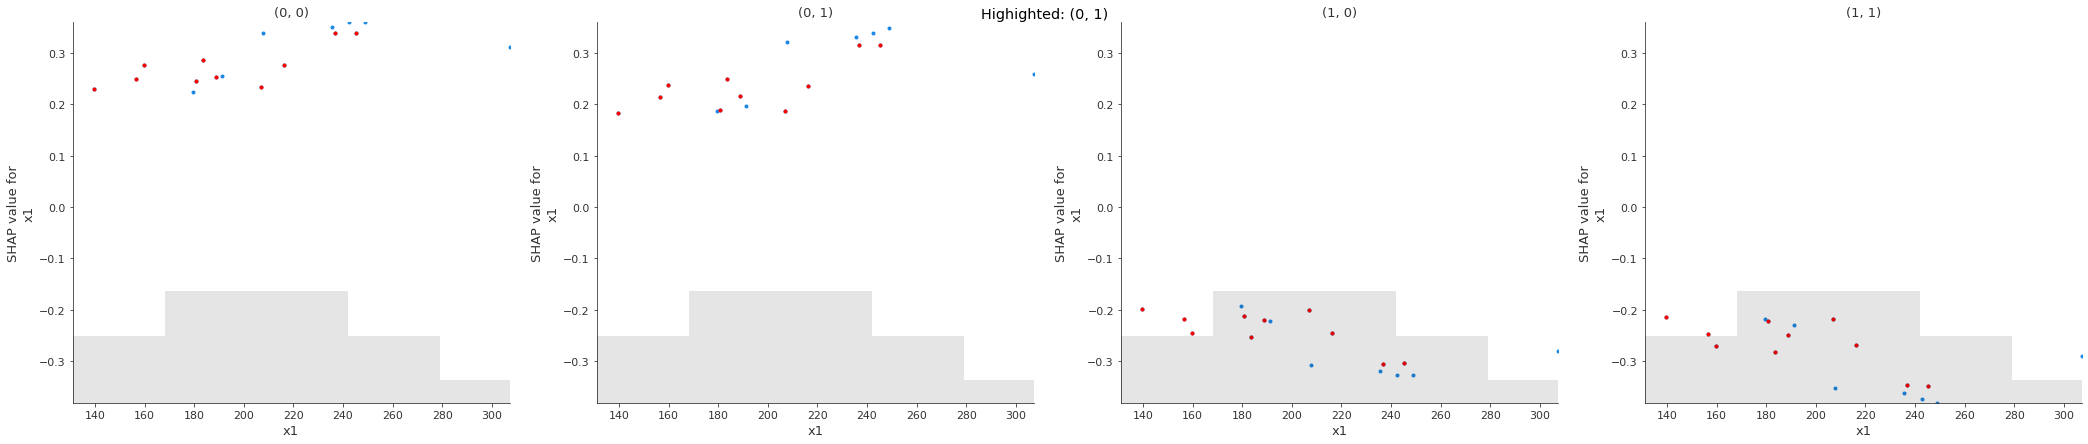

In [52]:
plot_next_feature()

With increasing values of x1, the effect shifts from $(0,0)$ and $(0,1)$ towards $(1,0)$ and $(1,1)$.

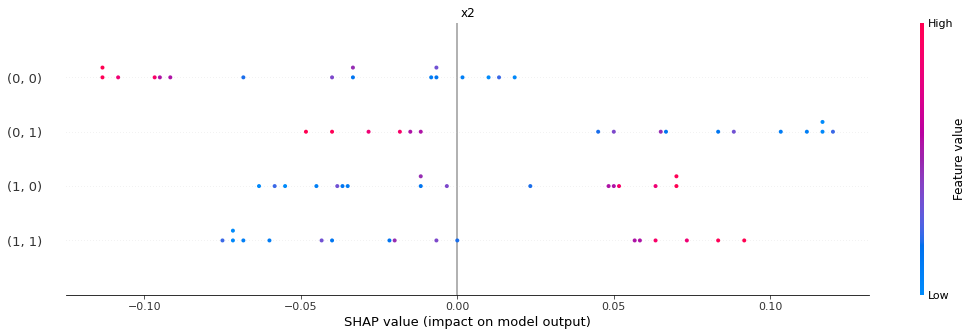

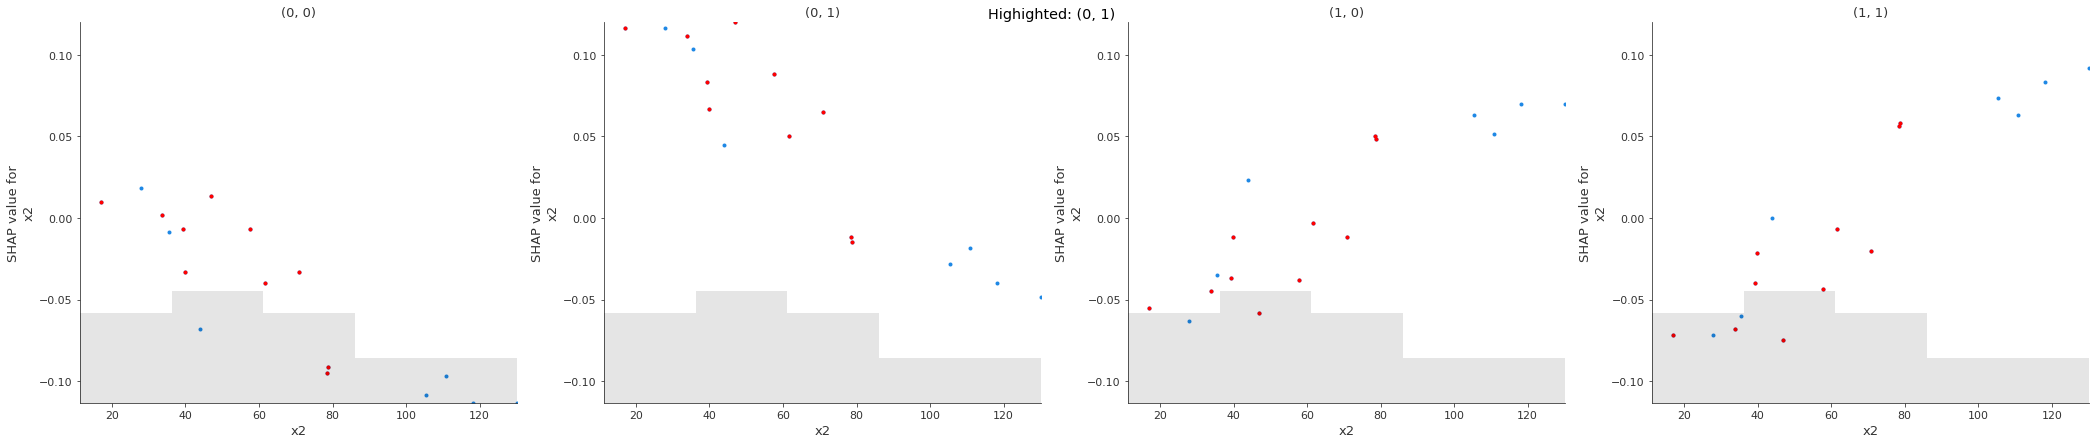

In [53]:
plot_next_feature()

In [54]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = 120
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",7.0,4
"(1, 0)",NaN,3


,before,after
"(0, 1)",10.0,3
"(1, 1)",NaN,7


### diro2c

diro2c had difficulties identifying the right decision boundaries. It may be because of the interacting effects between x1 and x2.

In [57]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [58]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 23.5 s, sys: 192 ms, total: 23.7 s
Wall time: 24.8 s


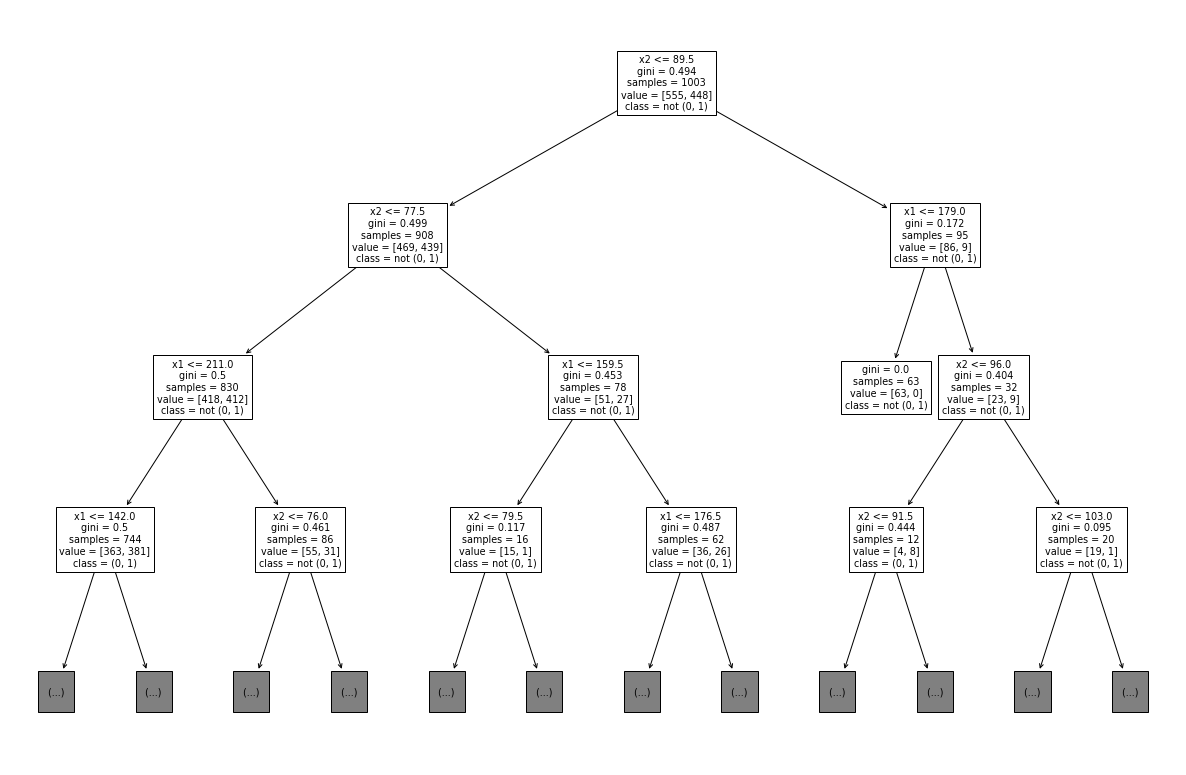

In [62]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

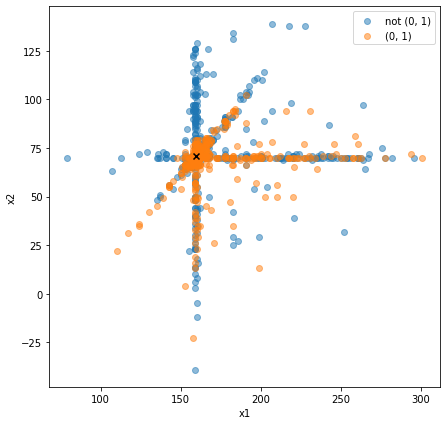

In [60]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)

## 2. Cluster

These feature value distributions are different locally compared to the global level:
- x2 only reaches from 40 upwards
- x1 only reaches from 35 to 240

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x2 was lower, the effect would shift towards $(0,0)$ and $(0,1)$: Setting it to -100 changes all predictions of instances originally classified $(1,0)$ to $(0,0)$, and all predictions of instances originally classified $(1,1)$ to $(0,1)$.

Locally, there are no effects present that could explain why some instances are classified equally and some are not.

In [63]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c2,0,0,39,53


In [64]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,92.000000,92.000000
mean,126.070661,123.546662
std,41.336418,40.216230
min,35.549945,63.080542
25%,97.083214,92.571128
50%,118.915466,111.302786
75%,146.239727,148.762921
max,240.183693,258.940851


In [65]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,39.0
"(1, 0)",39.0,NaN


,before,after
"(0, 1)",NaN,53.0
"(1, 1)",53.0,NaN


### SHAP-based Difference Classifier Explanations

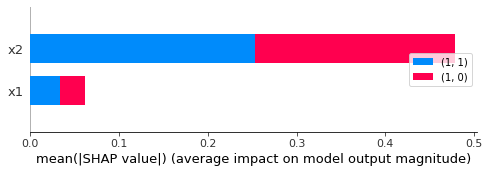

In [66]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

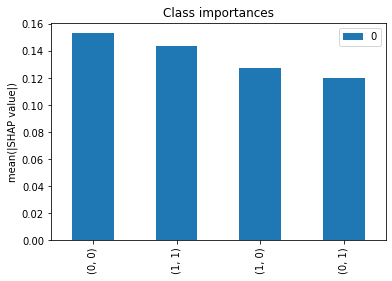

In [67]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [68]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

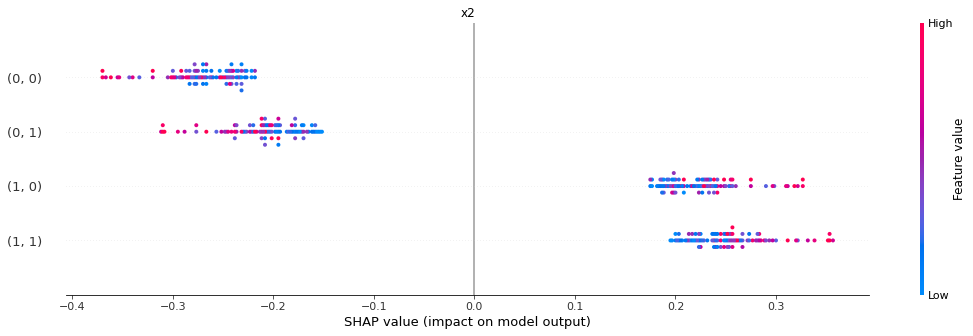

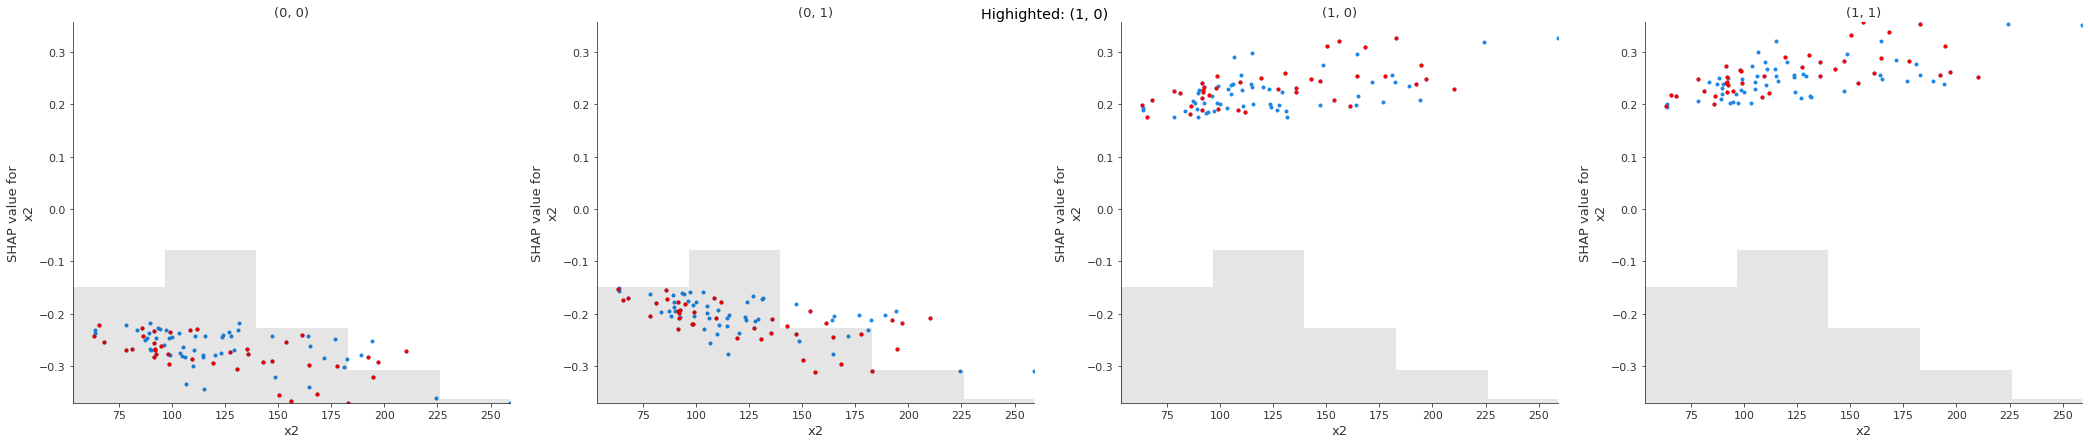

In [69]:
plot_next_feature()

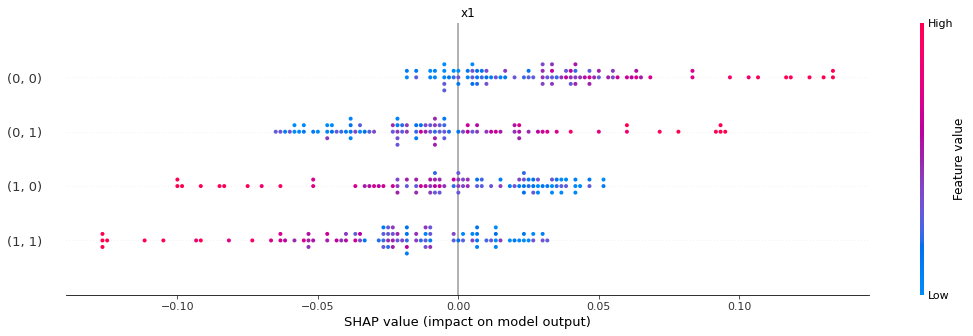

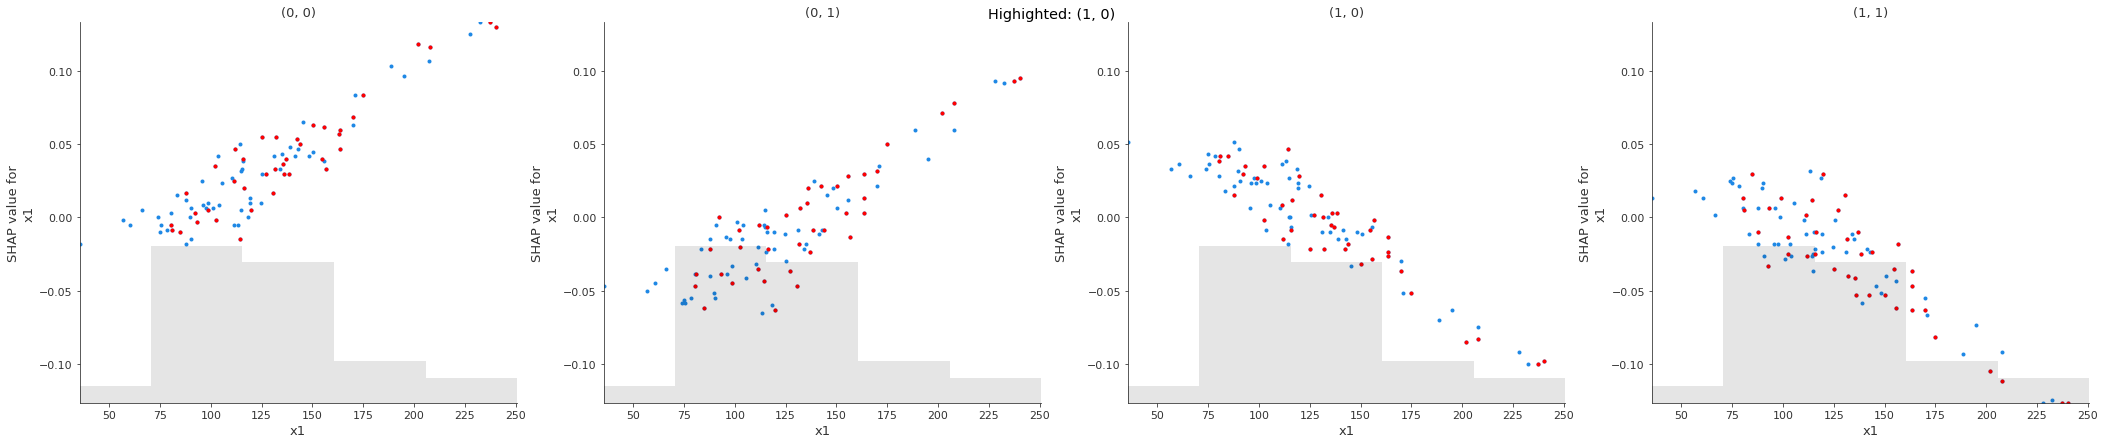

In [70]:
plot_next_feature()

### diro2c

In [72]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [73]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 21.1 s, sys: 152 ms, total: 21.3 s
Wall time: 21.5 s


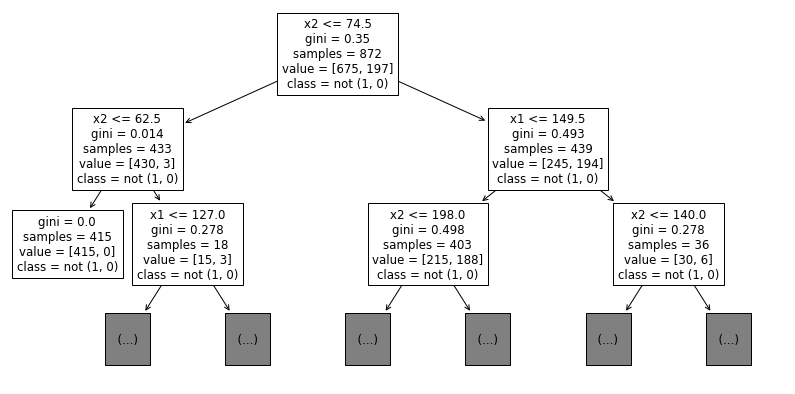

In [74]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=2)

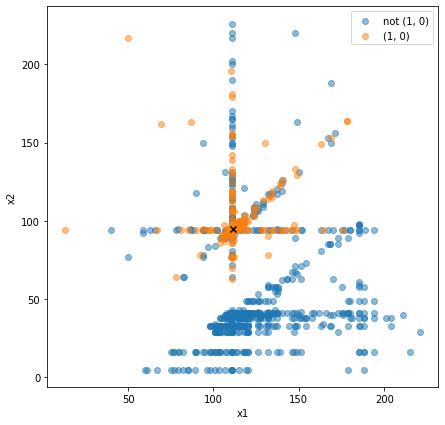

In [75]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)

## 3. Cluster

These feature value distributions are different locally compared to the global level:
- x2 only reaches from -27 to 108
- x1 only reaches from -43 to 113

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x2 was lower, the effect would shift towards $(0,0)$ and $(0,1)$: Setting it to -100 changes all predictions of instances originally classified $(1,0)$ to $(0,0)$, and all predictions of instances originally classified $(1,1)$ to $(0,1)$.

Locally, there are no effects present that could explain why some instances are classified equally and some are not.

In [76]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c3,0,0,31,41


In [77]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,72.000000,72.000000
mean,37.116101,43.941647
std,34.104707,33.630046
min,-43.736132,-27.904182
25%,10.138449,24.920221
50%,44.093899,45.659038
75%,63.470200,73.422117
max,113.255023,108.204518


In [78]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,31.0
"(1, 0)",31.0,NaN


,before,after
"(0, 1)",NaN,41.0
"(1, 1)",41.0,NaN


### SHAP-based Difference Classifier Explanations

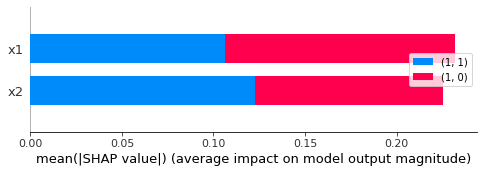

In [79]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

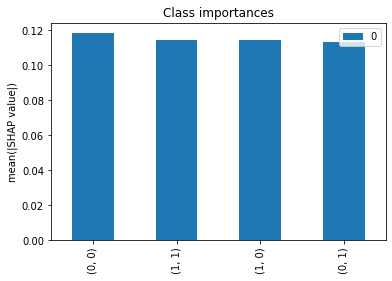

In [80]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [81]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

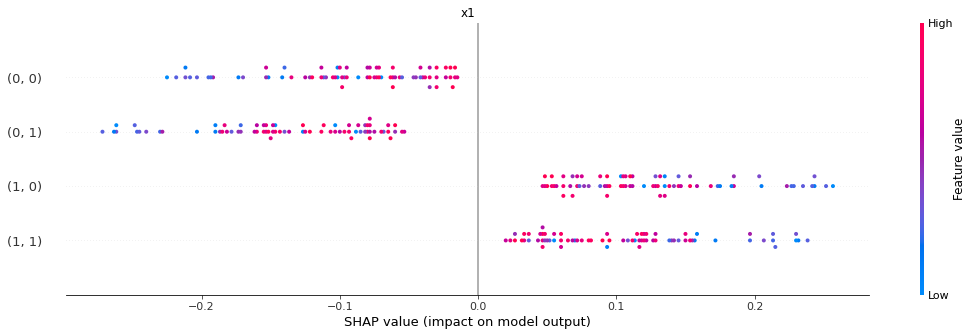

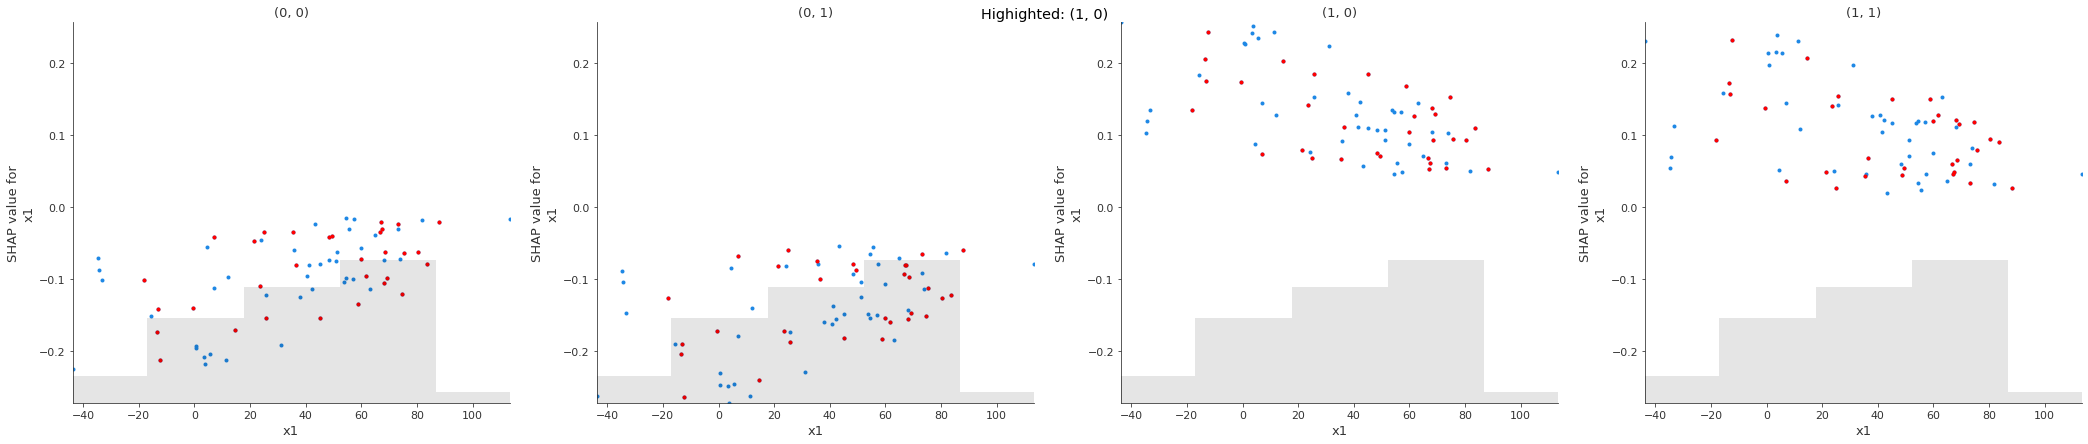

In [82]:
plot_next_feature()

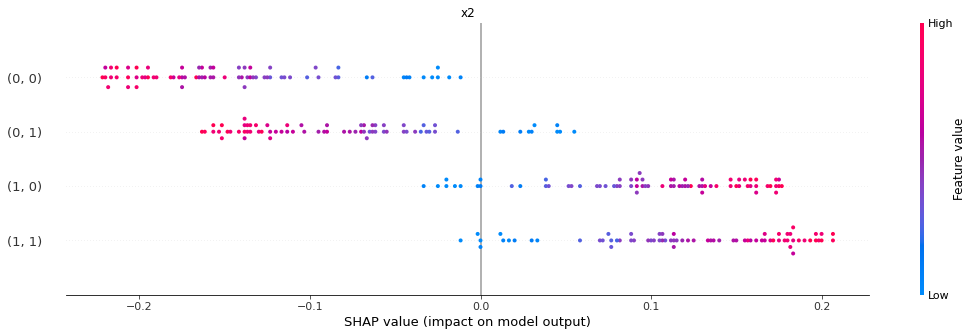

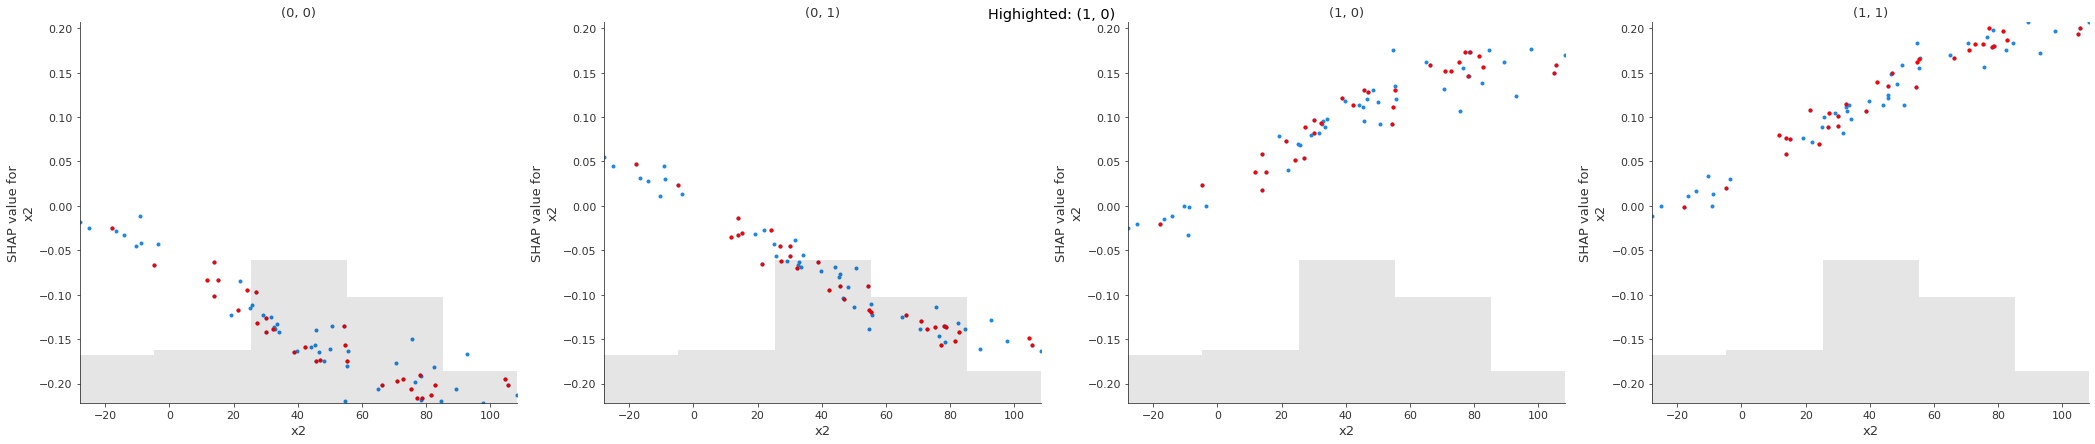

In [83]:
plot_next_feature()

### diro2c

In [84]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [85]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 22.1 s, sys: 228 ms, total: 22.3 s
Wall time: 22.7 s


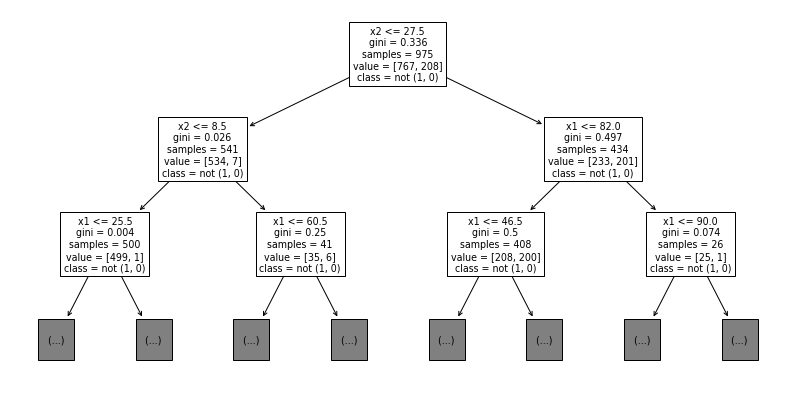

In [86]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=2)

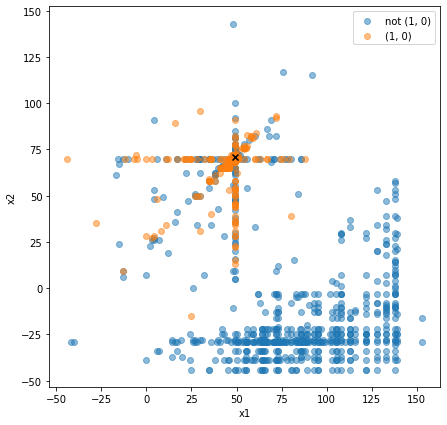

In [87]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)